In [ ]:
'''
Adapated from: https://github.com/CVxTz/kinship_prediction/blob/master/code/vgg_face.py
to parse the images and data
This is NOT used to make the model!
Additionally, this is run on a Windows OS. Some code may not be need if it is on a UNIX or LINUX OS.
'''
import pandas as pd
from glob import glob #for finding files recursively
from collections import defaultdict

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils
import torchvision.datasets as dset

from torch import optim
from torch.utils.data import DataLoader,Dataset
from torchvision.models import *
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
from PIL import Image

In [ ]:
!unzip '/content/train.zip' -d '/content/train'

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/F0099/MID1/P11523_face3.jpg  
  inflating: /content/train/F0099/MID1/P11536_face2.jpg  
  inflating: /content/train/F0099/MID1/P01025_face1.jpg  
  inflating: /content/train/F0099/MID1/P11539_face1.jpg  
  inflating: /content/train/F0099/MID1/P01021_face1.jpg  
  inflating: /content/train/F0099/MID1/P01026_face1.jpg  
  inflating: /content/train/F0099/MID1/P11519_face3.jpg  
  inflating: /content/train/F0099/MID1/P11535_face2.jpg  
  inflating: /content/train/F0099/MID1/P01027_face1.jpg  
  inflating: /content/train/F0099/MID1/P11518_face2.jpg  
  inflating: /content/train/F0099/MID1/P11520_face3.jpg  
  inflating: /content/train/F0099/MID6/P11523_face2.jpg  
  inflating: /content/train/F0099/MID6/P11518_face4.jpg  
  inflating: /content/train/F0099/MID6/P11522_face4.jpg  
  inflating: /content/train/F0099/MID6/P11519_face2.jpg  
  inflating: /content/train/F0099/MID6/P11539_face2.jpg  
  inflating: /content

In [ ]:
relationshipsCSV = "./train_relationships.csv"
train_images_folder = "./train/"
#what is the difference between train and train-face?


In [ ]:
available_images = glob(train_images_folder + "*/*/*.jpg")
'''
Only for windows pc:
'''
for a in range(0, len(available_images)):
    available_images[a] = available_images[a].replace("\\", "/")

all_ppl = [x.split("/")[-3] + "/" + x.split("/")[-2] for x in available_images] #all the people
all_ppl

['F0517/MID5',
 'F0517/MID5',
 'F0517/MID5',
 'F0517/MID5',
 'F0517/MID2',
 'F0517/MID2',
 'F0517/MID2',
 'F0517/MID2',
 'F0517/MID2',
 'F0517/MID2',
 'F0517/MID1',
 'F0517/MID1',
 'F0517/MID1',
 'F0517/MID1',
 'F0517/MID1',
 'F0517/MID1',
 'F0517/MID1',
 'F0517/MID1',
 'F0517/MID4',
 'F0517/MID4',
 'F0517/MID4',
 'F0517/MID4',
 'F0517/MID3',
 'F0517/MID3',
 'F0517/MID3',
 'F0517/MID3',
 'F0517/MID3',
 'F0517/MID3',
 'F0074/MID5',
 'F0074/MID2',
 'F0074/MID2',
 'F0074/MID2',
 'F0074/MID2',
 'F0074/MID1',
 'F0074/MID1',
 'F0074/MID1',
 'F0074/MID1',
 'F0074/MID1',
 'F0074/MID4',
 'F0074/MID4',
 'F0074/MID3',
 'F0074/MID3',
 'F0074/MID3',
 'F0074/MID3',
 'F0074/MID6',
 'F0074/MID6',
 'F0059/MID2',
 'F0059/MID2',
 'F0059/MID2',
 'F0059/MID2',
 'F0059/MID2',
 'F0059/MID2',
 'F0059/MID2',
 'F0059/MID1',
 'F0059/MID1',
 'F0059/MID1',
 'F0059/MID1',
 'F0059/MID1',
 'F0059/MID1',
 'F0059/MID4',
 'F0059/MID3',
 'F0059/MID3',
 'F0059/MID3',
 'F0059/MID3',
 'F0059/MID3',
 'F0059/MID3',
 'F0059/MI

In [ ]:
#creating the training set
personPathFile = defaultdict(list)
for x in available_images:
    personPathFile[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

#read from the csv to create a list of tuples
relationships = pd.read_csv(relationshipsCSV)
relationship_pairs = [(row['p1'], row['p2']) for index, row in relationships.iterrows()] # Create a list of tuples
relationship_pairs = [x for x in relationship_pairs if x[0] in all_ppl and x[1] in all_ppl] #data cleaning

#converting into dictionary of person is related to this list of people
relationshipDict = defaultdict(list)
for item in relationship_pairs:
  relationshipDict[item[0]].append(item[1]) #you do not need to consider the item[1] because the CSV is already pretty clean


#create more data by finding the 'negative pair'
notRelationshipDict = defaultdict(list)
set_all_ppl = set(all_ppl)
#for each key(person) in the relationship dictionary, find the non-relations
for k,v in relationshipDict.items():
    notRelationshipDict[k]=list(set_all_ppl-set(v))


# convert both dictionaries into a list of tuples with 1, 0 as labels
# for each of the image, take the first image path stored in the dictionary made earlier
# then take each of the path file in the item
trainData = []
for k,v in relationshipDict.items():
    for relation in v:
        for item in personPathFile[k]:
                trainData.append((item, personPathFile[relation][0],1))

print("Current Length of positive relationships: ", len(trainData))
for k,v in notRelationshipDict.items():
    for i in range(0,len(v)//170): #random number
        trainData.append((personPathFile[k][0],personPathFile[relation][0],0))


# Storing the list of tuples in a text file
# with open('Cleaned_Data.txt', 'w') as file:
#     for item in trainData:
#         file.write(f"{item[0]}, {item[1]}, {item[2]}\n")


# trainData1 = []
# with open('Cleaned_Data.txt', 'r') as file:
#     for l in file:
#         eachTuple = l.strip().split(', ')
#         trainData1.append(((eachTuple[0]), eachTuple[1], int(eachTuple[2])))

Current Length of positive relationships:  21283


In [ ]:
#Checking whether the trainData is created correctly
print("Total Length of all relationships: ", len(trainData))
print(trainData[:100]) #print the first 100

Total Length of all relationships:  42577
[('./train/F0002/MID1/P00017_face3.jpg', './train/F0002/MID3/P00015_face1.jpg', 1), ('./train/F0002/MID1/P00014_face2.jpg', './train/F0002/MID3/P00015_face1.jpg', 1), ('./train/F0002/MID1/P00015_face2.jpg', './train/F0002/MID3/P00015_face1.jpg', 1), ('./train/F0002/MID1/P00010_face4.jpg', './train/F0002/MID3/P00015_face1.jpg', 1), ('./train/F0002/MID1/P00018_face1.jpg', './train/F0002/MID3/P00015_face1.jpg', 1), ('./train/F0002/MID1/P00013_face2.jpg', './train/F0002/MID3/P00015_face1.jpg', 1), ('./train/F0002/MID1/P00009_face3.jpg', './train/F0002/MID3/P00015_face1.jpg', 1), ('./train/F0002/MID1/P00011_face1.jpg', './train/F0002/MID3/P00015_face1.jpg', 1), ('./train/F0002/MID1/P00016_face2.jpg', './train/F0002/MID3/P00015_face1.jpg', 1), ('./train/F0002/MID1/P00012_face2.jpg', './train/F0002/MID3/P00015_face1.jpg', 1), ('./train/F0002/MID2/P00011_face2.jpg', './train/F0002/MID3/P00015_face1.jpg', 1), ('./train/F0002/MID2/P00018_face3.jpg', './t

In [ ]:
dfTrainData = pd.DataFrame (trainData, columns=['img1', 'img2', 'class'])

In [ ]:
dfTrainData

,img1,img2,class
0,./train/F0002/MID1/P00017_face3.jpg,./train/F0002/MID3/P00015_face1.jpg,1
1,./train/F0002/MID1/P00014_face2.jpg,./train/F0002/MID3/P00015_face1.jpg,1
2,./train/F0002/MID1/P00015_face2.jpg,./train/F0002/MID3/P00015_face1.jpg,1
3,./train/F0002/MID1/P00010_face4.jpg,./train/F0002/MID3/P00015_face1.jpg,1
4,./train/F0002/MID1/P00018_face1.jpg,./train/F0002/MID3/P00015_face1.jpg,1
...,...,...,...
42572,./train/F1000/MID7/P10581_face1.jpg,./train/F1000/MID9/P10578_face4.jpg,0
42573,./train/F1000/MID7/P10581_face1.jpg,./train/F1000/MID9/P10578_face4.jpg,0
42574,./train/F1000/MID7/P10581_face1.jpg,./train/F1000/MID9/P10578_face4.jpg,0
42575,./train/F1000/MID7/P10581_face1.jpg,./train/F1000/MID9/P10578_face4.jpg,0


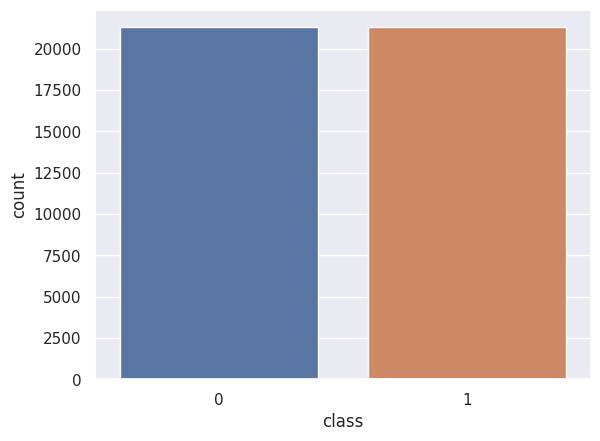

In [ ]:
#checking the balance of positive and negative data
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x="class", data=dfTrainData)

In [ ]:
'''
Adapted from: https://github.com/ale-mauro/Kinship-Recognition/blob/main/KinshipRecognition_Naive_DenseNet161_ResNet.ipynb
Obtaining the training and validation set to use the following model:
https://keras.io/examples/vision/siamese_network/

The idea is to split to obtain a "triple" set:
1. an anchor
2. positive
3. negative
'''

'\nAdapted from: https://github.com/ale-mauro/Kinship-Recognition/blob/main/KinshipRecognition_Naive_DenseNet161_ResNet.ipynb\nObtaining the training and validation set to use the following model:\nhttps://keras.io/examples/vision/siamese_network/\n\nThe idea is to split to obtain a "triple" set:\n1. an anchor\n2. positive\n3. negative\n'

In [ ]:
#use the pytorch built in Dataset function
class trainingDataset(Dataset):
    def __init__(self, _data, _transform=None):
        self.data = _data #choose either train or val dataset to use
        self.transform = _transform


    def __getitem__(self,index):

        first_img_path = self.data[index][0]
        second_img_path = self.data[index][1]
        img1Opened = Image.open(first_img_path)
        img2Opened = Image.open(second_img_path)


        #it is important to transform the images into tensor format
        if self.transform is not None:
            img1Opened = self.transform(img1Opened)
            img2Opened = self.transform(img2Opened)
        return img1Opened, img2Opened , self.data[index][2]

    def __len__(self):
        return len(self.data)#essential for choose the num of data in one epoch


In [ ]:
from sklearn.model_selection import train_test_split
BATCH_SIZE=64
IMG_SIZE=100
NUM_WORKERS = 8


trainSet, valSet = train_test_split(trainData, test_size=0.1, random_state=42)

#TODO: Normalize the data

#Training set and training loader
trainset = trainingDataset(_data=trainSet,
                                        _transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))

valset = trainingDataset(_data=valSet,
                                        _transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))



trainloader = DataLoader(trainset,
                        shuffle=True,
                        num_workers=NUM_WORKERS,
                        batch_size=BATCH_SIZE)


valloader = DataLoader(valset,
                        shuffle=True,
                        num_workers=NUM_WORKERS,
                        batch_size=BATCH_SIZE)


In [ ]:
import torchvision.models as models

class SiameseVGG(nn.Module):
    def __init__(self):
        super(SiameseVGG, self).__init__()

        model = models.vgg19(pretrained=True) #Carico VGGFace19 già allenata
        #Freezing tutti i layers
        for param in model.parameters():
          param.require_grad = False

        #Estrazione blocco convoluzionale
        self.cnn1 = torch.nn.Sequential(*(list(model.children())[:-1]))

        #Aggiungo nuovi layers pienamente connessi
        model.classifier = nn.Sequential(
            nn.Linear(50176, 460),
            nn.ReLU(),
            nn.Linear(460, 230),
            nn.ReLU(),
            nn.Linear(230, 2)
        )

        self.fc = model.classifier

    def forward(self, input1, input2):
        output1 = self.cnn1(input1)
        output1 = output1.view(output1.size()[0], -1)
        output2 = self.cnn1(input2)
        output2 = output2.view(output2.size()[0], -1)

        output = torch.cat((output1, output2),1)
        #print(output.shape) #è l'output che deve aver il primo fc
        output = self.fc(output)
        return output

# Create an instance of the SiameseVGG network.
model = SiameseVGG()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#Here you can chose the network you want by changing the Siamese Network
net = SiameseVGG().cuda()
criterion = nn.CrossEntropyLoss() # use a Classification Cross-Entropy loss
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [ ]:
import numpy as np

counter = []
loss_history = []
iteration_number= 0

BATCH_SIZE=64
NUMBER_EPOCHS=10
epoch_accuracies = np.array([])

for epoch in range(0,NUMBER_EPOCHS):
    print("Epoch：", epoch, " start.")
    for i, data in enumerate(trainloader,0):
        img0, img1 , labels = data #img=tensor[batch_size,channels,width,length], label=tensor[batch_size,label]
        img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()#move to GPU

        optimizer.zero_grad()#clear the calculated grad in previous batch
        outputs = net(img0,img1)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        if i %10 == 0 :#show changes of loss value after each 10 batches
            #print("Epoch number {}\n Current loss {}\n".format(epoch,loss.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss.item())

    #test the network after finish each epoch, to have a brief training result.
    correct_val = 0
    total_val = 0
    with torch.no_grad(): #essential for testing!
        for data in valloader:
            img0, img1 , labels = data
            img0, img1 , labels = img0.cuda(), img1.cuda() , labels.cuda()
            outputs = net(img0,img1)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    accuracy = 100 * correct_val / total_val
    epoch_accuracies = np.append(epoch_accuracies, accuracy)

    # print('Accuracy of the network on the', total_val, 'val pairs in', val_families, ': %d %%' % (100 * correct_val / total_val))
    # show_plot(counter,loss_history)
    print(f"Epoch [{epoch+1}/{NUMBER_EPOCHS}] Accuracy: {accuracy}")

best_accuracy = np.amax(epoch_accuracies)
best_epoch = epoch_accuracies.argmax()
print('END TRAINING: BEST EPOCH: ', best_epoch, ' WITH ACCURACY: ', best_accuracy)


Epoch： 0  start.
Epoch [1/10] Accuracy: 100.0
Epoch： 1  start.
Epoch [2/10] Accuracy: 100.0
Epoch： 2  start.
Epoch [3/10] Accuracy: 100.0
Epoch： 3  start.
Epoch [4/10] Accuracy: 100.0
Epoch： 4  start.
Epoch [5/10] Accuracy: 100.0
Epoch： 5  start.
Epoch [6/10] Accuracy: 100.0
Epoch： 6  start.
Epoch [7/10] Accuracy: 100.0
Epoch： 7  start.
Epoch [8/10] Accuracy: 100.0
Epoch： 8  start.
Epoch [9/10] Accuracy: 100.0
Epoch： 9  start.
Epoch [10/10] Accuracy: 100.0
END TRAINING: BEST EPOCH:  0  WITH ACCURACY:  100.0


In [ ]:
!unzip '/content/test.zip' -d '/content/test'

unzip:  cannot find or open /content/test.zip, /content/test.zip.zip or /content/test.zip.ZIP.


In [ ]:
class testDataset(Dataset): #different from train dataset, because the data organized in submission.csv is different from train.csv

    def __init__(self,transform=None):
        self.test_df = pd.read_csv('/content/drive/MyDrive/ComputerVisionProject/kinship-dataset/sample_submission.csv')
        self.transform = transform

    def __getitem__(self,index):
        #data in submission.csv:
        #       img_pair               is_related
        #face05508.jpg-face01210.jpg       0
        #face05820.jpg-face03938.jpg       0

        img0_path = self.test_df.iloc[index].img_pair.split("-")[0]
        img1_path = self.test_df.iloc[index].img_pair.split("-")[1]

        img0 = Image.open('test/'+img0_path)
        img1 = Image.open('test/'+img1_path)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1

    def __len__(self):
        return len(self.test_df)

In [ ]:
testset = testDataset(transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))
testloader = DataLoader(testset,
                        shuffle=False,
                        num_workers=0,
                        batch_size=1)#Both extra workers and batch size lead to data out of order, the submission.csv will be

FileNotFoundError: ignored

In [ ]:

#Testing impiega circa 1 minuto (per Naive) e circa 5 minuti (per reti preaddestrate)
test_df = pd.read_csv('/content/drive/MyDrive/ComputerVisionProject/kinship-dataset/sample_submission.csv')
predictions=[]
with torch.no_grad():
    for data in testloader:
        img0, img1 = data
        img0, img1 = img0.cuda(), img1.cuda()
        outputs = net(img0,img1)
        _, predicted = torch.max(outputs, 1)
        predictions = np.concatenate((predictions,predicted.cpu().numpy()),0)

test_df['is_related'] = predictions
test_df.to_csv("test_Results.csv", index=False) #submission.csv should be placed directly in current fold.
test_df.head(50)#show the result to be committed

In [ ]:
# # Salvataggio modello
# saved_path = "/content/drive/MyDrive/ComputerVisionProject/pretrained_model/NaiveNet(test).pth"
# torch.save(net, saved_path)